<a href="https://colab.research.google.com/github/sekihiro/Colabo/blob/master/TransFormationLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 転移学習 (PreTrainded Model : ResNet18)
#### 転移学習とファインチューニングは、どちらも既存のモデルを応用したディープラーニングの学習方法
- 転移学習 ： 既存の学習済モデル（出力層以外の部分）を、重みデータは変更せずに特徴量抽出機として利用する。
- ファインチューニング ： 既存の学習済モデル（出力層以外の部分）を、重みデータを一部再学習して特徴量抽出機として利用する。

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!nvidia-smi

Mon Feb 10 14:14:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [5]:
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [6]:
# 必要なデータは下記サイトから事前にダウンロードしておく
### !wget https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz
### !tar xf taco_and_burrito.tar.gz

%ls "/content/drive/My Drive/git/taco/images/taco_and_burrito/"*

'/content/drive/My Drive/git/taco/images/taco_and_burrito/test':
burrito/  taco/

'/content/drive/My Drive/git/taco/images/taco_and_burrito/_tmp':

'/content/drive/My Drive/git/taco/images/taco_and_burrito/train':
burrito/  taco/


In [0]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dsets
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import easydict
import time
import math
import random
import os
import cv2
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cloudpickle

In [0]:
# 再現性確保
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    return seed

In [9]:
# 再現性確保
ret = seed_everything(1234)
print('seed : {}'.format(ret))

# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device : {}'.format(device))

# ImageFolder関数を使用してDatasetを作成する
# 学習済モデルのResNetは、224×224の画像をINPUTにするので、ランダムな位置で切り出す(crop)
BASE_PATH = "/content/drive/My Drive/git/taco/images/taco_and_burrito/"
train_imgs = ImageFolder(
    BASE_PATH + "train/",
    transform=transforms.Compose([
      transforms.RandomCrop(224),
      transforms.ToTensor()]
))
valid_imgs = ImageFolder(
    BASE_PATH + "test/",
    transform=transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()]
))

# DataLoaderを作成
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_imgs, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(
    valid_imgs, batch_size=batch_size, shuffle=False)

print('train_dataset = ', len(train_imgs))
print('valid_dataset = ', len(valid_imgs))
print('train_loader = ', len(train_loader))
print('valid_loader = ', len(valid_loader))

seed : 1234
device : cuda
train_dataset =  712
valid_dataset =  60
train_loader =  23
valid_loader =  2


(N, C, H, W) = (1, 3, 256, 341)
(N, C, H, W) = (1, 3, 256, 256)
(N, C, H, W) = (1, 3, 256, 481)
(N, C, H, W) = (1, 3, 224, 224)
(N, C, H, W) = (1, 3, 224, 224)
(N, C, H, W) = (1, 3, 224, 224)


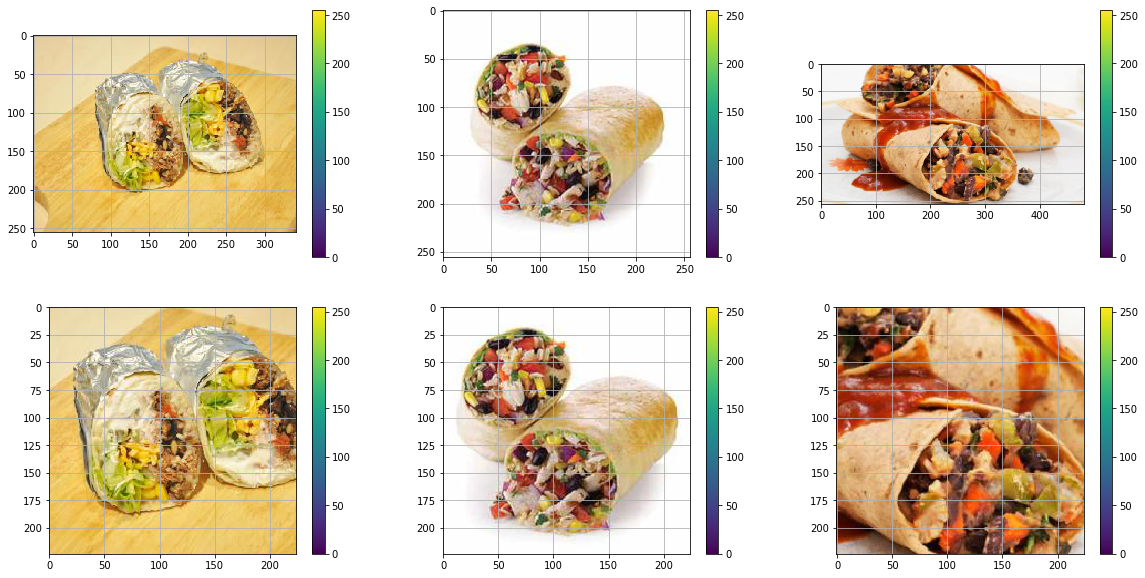

In [10]:
# ******************** wkデータ ******************** #
# どんな画像かを試しに表示してみる

plt.figure(figsize=(20, 10))
wk_num = 3

tmp_imgs = ImageFolder(
    BASE_PATH + "test/",
    transform=transforms.Compose([
        transforms.ToTensor()]
))
tmp_loader = torch.utils.data.DataLoader(
    tmp_imgs, batch_size=1, shuffle=False)

# オリジナル画像
for i, (tmp_images, tmp_labels) in enumerate(tmp_loader):

        tmp_numpy_array = tmp_images.numpy()
        tmp_ret = tmp_numpy_array.shape # N,C,H,W
        print('(N, C, H, W) = {}'.format(tmp_ret))

        # Tensor形式のまま、一時的にファイルに書き出す
        TMP_IMG = BASE_PATH + '_tmp/' + str(i).zfill(3) + '_org.png'
        torchvision.utils.save_image(tmp_images, TMP_IMG)
         
        # 一時ファイルを読み込み、matplotへ貼り付け
        im = cv2.imread(TMP_IMG)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.subplot(2, wk_num, i+1)
        plt.imshow(im)
        plt.colorbar()
        plt.grid(True)
        os.remove(TMP_IMG)

        if i >= (wk_num-1):
            break


# CROPした画像
wk_loader = torch.utils.data.DataLoader(
    valid_imgs, batch_size=1, shuffle=False)

for i, (wk_images, wk_labels) in enumerate(wk_loader):

        #print(type(wk_images))
        wk_numpy_array = wk_images.numpy()
        wk_ret = wk_numpy_array.shape # N,C,H,W
        print('(N, C, H, W) = {}'.format(wk_ret))

        # Tensor形式のまま、一時的にファイルに書き出す
        TMP_IMG = BASE_PATH + '_tmp/' + str(i).zfill(3) + '_crop.png'
        torchvision.utils.save_image(wk_images, TMP_IMG)
         
        # 一時ファイルを読み込み、matplotへ貼り付け
        im = cv2.imread(TMP_IMG)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.subplot(2, wk_num, i+1+wk_num)
        plt.imshow(im)
        plt.colorbar()
        plt.grid(True)
        os.remove(TMP_IMG)

        if i >= (wk_num-1):
            break

# 画像表示
plt.show()
# ******************** wkデータ ******************** #

In [11]:
print(type(train_imgs))
print(train_imgs.classes)
print(train_imgs.class_to_idx)

<class 'torchvision.datasets.folder.ImageFolder'>
['burrito', 'taco']
{'burrito': 0, 'taco': 1}


In [0]:
def train_eval(net, only_fc, train_loader, valid_loader, device):

    ###  training
    print('training start ...\n')

    # 損失関数：ラベル値と予測値の違いを計算するための関数
    criterion = nn.CrossEntropyLoss()

    # 最適化関数(勾配法)：損失関数の最小化を解く手法
    # SGD(Stochastic Gradient Descent)：確率的勾配降下法
    if only_fc == True:
        # 転移学習の場合
        # optimizerに渡すのはFCパラメータのみ
        print('only_fc\n')
        optimizer = optim.SGD(net.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4) 
    else:
        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4) 

    time.sleep(1)
    num_epochs = 10   

    # initialize list for plot graph after training
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

    for epoch in range(num_epochs):
        # initialize each epoch
        train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
        
        # ======== train_mode ======
        net.train()
        for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader), desc="[train]"):  # ミニバッチ回数実行
            images, labels = images.to(device), labels.to(device)
            # 毎回バックプロパゲーションの初期値をリセット(勾配リセット)
            optimizer.zero_grad()
            # 順方向の伝播の計算(forwardが呼ばれる)
            outputs = net.forward(images)
            # 損失関数：予測値とラベル値の違いを計算
            loss = criterion(outputs, labels)
            # train_loss に結果を蓄積
            # item()で、Tensorをintへ
            train_loss += loss.item()
            # パターンの分類毎に値が取得できるので、最も値が高い分類をmax(1)で取得
            # max(1)の戻り値の[0]はsoftmaxの精度(0〜1)、[1]は予測ラベル
            # 予測とラベルが合っている数の合計
            # sum()は、合っている数をTensor形式でカウント
            # item()で、Tensorをintへ
            acc = (outputs.max(1)[1] == labels).sum()
            # train_acc に結果を蓄積
            train_acc += acc.item()
            # 誤差のバックプロパゲーション(逆伝播)で勾配を求める
            loss.backward()
            # バックプロパゲーションで計算した勾配を元に重みを更新
            optimizer.step()  # 重みの更新
        
        # lossの平均を計算
        avg_train_loss = train_loss / len(train_loader.dataset)
        # accの平均を計算
        avg_train_acc = train_acc / len(train_loader.dataset)
        
        # ======== valid_mode ======
        net.eval()
        # torch.no_gradで必要のない計算を停止 パラメータの保存を止める(test時にメモリが溢れてしまうのを防止)
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, total=len(valid_loader), desc="[valid]"):
                images, labels = images.to(device), labels.to(device)
                outputs = net.forward(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                acc = (outputs.max(1)[1] == labels).sum()
                val_acc += acc.item()
        
        avg_val_loss = val_loss / len(valid_loader.dataset)
        avg_val_acc = val_acc / len(valid_loader.dataset)
        
        # print log
        print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}\n' 
                    .format(epoch+1, num_epochs, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
        time.sleep(1)

        # append list for polt graph after training
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

    print ('training end ...')

### 事前学習済みモデルのResNet18をロード

In [13]:
net = models.resnet18(pretrained=True)

#for param in net.parameters():
#    print(param)

# PyTorchは、Defined by Run (Tensor計算をするごとに自動的にモデルを組むことができる)
# 順伝播のコードを書くだけで逆伝播が定義できる
# autogradは自動微分機能を提供する、このパッケージを使うと勝手に微分の計算をしてくれる
# デフォルトで、requires_grad=True

# 転移学習では、モデルのパラメータを固定
# すべてのパラメータを微分対象外にする
for p in net.parameters():
    p.requires_grad=False

# 最後の線形層を付け替える
# ResNet18では、出力の線形層がfcという名前で取得できる
# 2クラス分類用に、線形層の出力の次元を2とする
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)
pprint.pprint(net)

net.to(device)

print('PreTrained Model(ResNet18) Loaded...')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

#### PreTrained Model を使う場合

In [14]:
train_eval(net, True, train_loader, valid_loader, device)   # ACC:88%くらい

training start ...

only_fc



[valid]: 100%|██████████| 2/2 [00:16<00:00,  8.21s/it]


Epoch [1/10], Loss: 0.0333, val_loss: 0.0124, val_acc: 0.8667



[valid]: 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Epoch [2/10], Loss: 0.0204, val_loss: 0.0127, val_acc: 0.9000



[valid]: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Epoch [3/10], Loss: 0.0140, val_loss: 0.0130, val_acc: 0.8833



[valid]: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


Epoch [4/10], Loss: 0.0219, val_loss: 0.0118, val_acc: 0.8833



[valid]: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


Epoch [5/10], Loss: 0.0319, val_loss: 0.0147, val_acc: 0.8833



[valid]: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Epoch [6/10], Loss: 0.0131, val_loss: 0.0194, val_acc: 0.8000



[valid]: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]


Epoch [7/10], Loss: 0.0138, val_loss: 0.0154, val_acc: 0.8667



[valid]: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


Epoch [8/10], Loss: 0.0100, val_loss: 0.0136, val_acc: 0.8333



[valid]: 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


Epoch [9/10], Loss: 0.0101, val_loss: 0.0232, val_acc: 0.8333



[valid]: 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


Epoch [10/10], Loss: 0.0120, val_loss: 0.0170, val_acc: 0.8667

training end ...


#### 自作モデル

In [15]:
# Multi Layer Perceptron Network
class net(nn.Module):
    def __init__(self):
        super(net,self).__init__()
        #畳み込み層
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 5), # 第１引数は、CHWのCの値と合わせること
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.25),
        )
        #全結合層
        self.dence = nn.Sequential(
            nn.Linear( 64* 53 *53, 200), # 第１引数はcheck_cnn_sizeで算出
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Dropout(0.2),
            nn.Linear(200, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 10),
        )
         
    #順伝播
    def forward(self,x):
        #畳み込み層
        out = self.conv_layers(x)
        #Flatten
        #viewで画像の[C,H,W]を１次元に変換
        #引数に-1を入れることで、サイズ数を自動的に調整
        # [N,C,H,W] -> [N(out.size(0)), C*H*W]
        out = out.view(out.size(0), -1)
        #全結合層
        out = self.dence(out)
        return out
     
    #畳み込み層の出力サイズのチェック
    def check_cnn_size(self, size_check):
        out = self.conv_layers(size_check)
        return out

# MLP init
net = net().to(device)
pprint.pprint(net)

#全結合層の入力サイズの確認
#畳み込み層を通って、Flattenを通ったあと、どのようなサイズになっているか見ておく
size_check = torch.FloatTensor(2, 3, 224, 224) # ラベル2種類、カラーケール(C=3)、画像サイズ(224*224)
size_check = size_check.to(device)
print(net.check_cnn_size(size_check).size()) # ---> torch.Size([2, 64, 53, 53])

net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.25, inplace=False)
  )
  (dence): Sequential(
    (0): Linear(in_features=179776, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=200, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

#### PreTrained Model を使わない場合

In [16]:
train_eval(net, False, train_loader, valid_loader, device)   # ACC:50%くらい

training start ...



[valid]: 100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch [1/10], Loss: 0.0671, val_loss: 0.1958, val_acc: 0.5000



[valid]: 100%|██████████| 2/2 [00:00<00:00,  7.88it/s]


Epoch [2/10], Loss: 0.0455, val_loss: 0.0849, val_acc: 0.5000



[valid]: 100%|██████████| 2/2 [00:00<00:00,  7.23it/s]


Epoch [3/10], Loss: 0.0297, val_loss: 0.0901, val_acc: 0.5000



[valid]: 100%|██████████| 2/2 [00:00<00:00,  7.66it/s]


Epoch [4/10], Loss: 0.0237, val_loss: 0.0678, val_acc: 0.5000



[valid]: 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]


Epoch [5/10], Loss: 0.0224, val_loss: 0.0513, val_acc: 0.5000



[valid]: 100%|██████████| 2/2 [00:00<00:00,  7.97it/s]


Epoch [6/10], Loss: 0.0212, val_loss: 0.0691, val_acc: 0.5000



[valid]: 100%|██████████| 2/2 [00:00<00:00,  7.84it/s]


Epoch [7/10], Loss: 0.0191, val_loss: 0.0834, val_acc: 0.5000



[valid]: 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Epoch [8/10], Loss: 0.0190, val_loss: 0.0972, val_acc: 0.5000



[valid]: 100%|██████████| 2/2 [00:00<00:00,  7.75it/s]


Epoch [9/10], Loss: 0.0201, val_loss: 0.0703, val_acc: 0.5000



[valid]: 100%|██████████| 2/2 [00:00<00:00,  7.70it/s]


Epoch [10/10], Loss: 0.0193, val_loss: 0.0675, val_acc: 0.5000

training end ...
